In [1]:
import random
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
SEED = 1
BATCH_SIZE = 256
LR = 0.0003
UP_COEF = 0.1
GAMMA = 0.99
EPS = 1e-8

# set device
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.SELU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, 1)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.SELU(),
            nn.Linear(256, action_space)
        )

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).reshape(out.shape[0], 1)
        adv_out = self.adv(out).reshape(out.shape[0], -1)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        q = val_out + adv_out - adv_mean

        return q

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = random.sample(rep_memory, BATCH_SIZE)
    dataloader = DataLoader(
        train_data, batch_size=BATCH_SIZE, pin_memory=use_cuda)
    # double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.detach().to(device).long()
        _s_batch = _s.to(device).float()
        r_batch = r.detach().to(device).float()
        done_mask = 1 - d.detach().to(device).float()
        
        _q_batch = net(_s_batch)
        _a_batch = torch.argmax(_q_batch, dim=1)

        with torch.no_grad():
            _q_batch_tgt = tgt_net(_s_batch)
            _q_best_tgt = _q_batch_tgt[range(BATCH_SIZE), _a_batch]

        q_batch = net(s_batch)
        q_acting = q_batch[range(BATCH_SIZE), a_batch]

        # loss
        loss = ((r_batch + GAMMA * done_mask* _q_best_tgt) - q_acting).pow(2).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def select_action(obs, tgt_net):
    tgt_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        q = tgt_net(state)
        action = torch.argmax(q, dim=1)

    return action.item()

## Main

In [5]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
learn_start = 1500
memory_size = 50000
update_frq = 1
use_eps_decay = False
epsilon = 0.001
eps_min = 0.001
decay_rate = 0.0001
n_eval = env.spec.trials

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = DuelingDQN(obs_space, action_space).to(device)
target_net = deepcopy(net)

# make optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.trials

100

In [9]:
env.spec.reward_threshold

-110.0

In [10]:
# play
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = select_action(obs, target_net)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward

        if use_eps_decay:
            epsilon -= epsilon * decay_rate
            epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            # target smoothing update
            for t, n in zip(target_net.parameters(), net.parameters()):
                t.data = UP_COEF * n.data + (1 - UP_COEF) * t.data
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                torch.save(target_net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_dddqn.pt')
                break
env.close()

  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00
  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00

============  Start Learning  ============

  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3600 steps, reward -200.00
 19 Episode in  3800 steps, reward -200.00
 20 Episode in  4000 steps, reward -200.00
 21 Episode in  4200 steps, reward -200.00
 22 Episode in  4400 steps, reward -200.00
 23 Episo

192 Episode in 30557 steps, reward -164.00
193 Episode in 30650 steps, reward -93.00
194 Episode in 30797 steps, reward -147.00
195 Episode in 30946 steps, reward -149.00
196 Episode in 31095 steps, reward -149.00
197 Episode in 31251 steps, reward -156.00
198 Episode in 31407 steps, reward -156.00
199 Episode in 31493 steps, reward -86.00
200 Episode in 31586 steps, reward -93.00
201 Episode in 31735 steps, reward -149.00
202 Episode in 31883 steps, reward -148.00
203 Episode in 31985 steps, reward -102.00
204 Episode in 32130 steps, reward -145.00
205 Episode in 32266 steps, reward -136.00
206 Episode in 32373 steps, reward -107.00
207 Episode in 32547 steps, reward -174.00
208 Episode in 32694 steps, reward -147.00
209 Episode in 32783 steps, reward -89.00
210 Episode in 32920 steps, reward -137.00
211 Episode in 33079 steps, reward -159.00
212 Episode in 33229 steps, reward -150.00
213 Episode in 33385 steps, reward -156.00
214 Episode in 33485 steps, reward -100.00
215 Episode in 

384 Episode in 55575 steps, reward -158.00
385 Episode in 55686 steps, reward -111.00
386 Episode in 55797 steps, reward -111.00
387 Episode in 55945 steps, reward -148.00
388 Episode in 56034 steps, reward -89.00
389 Episode in 56173 steps, reward -139.00
390 Episode in 56265 steps, reward -92.00
391 Episode in 56368 steps, reward -103.00
392 Episode in 56515 steps, reward -147.00
393 Episode in 56654 steps, reward -139.00
394 Episode in 56798 steps, reward -144.00
395 Episode in 56953 steps, reward -155.00
396 Episode in 57099 steps, reward -146.00
397 Episode in 57241 steps, reward -142.00
398 Episode in 57376 steps, reward -135.00
399 Episode in 57503 steps, reward -127.00
400 Episode in 57646 steps, reward -143.00
401 Episode in 57792 steps, reward -146.00
402 Episode in 57935 steps, reward -143.00
403 Episode in 58092 steps, reward -157.00
404 Episode in 58245 steps, reward -153.00
405 Episode in 58395 steps, reward -150.00
406 Episode in 58545 steps, reward -150.00
407 Episode i

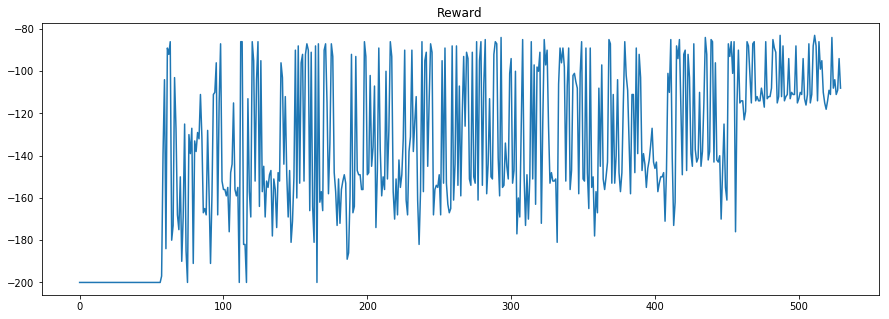

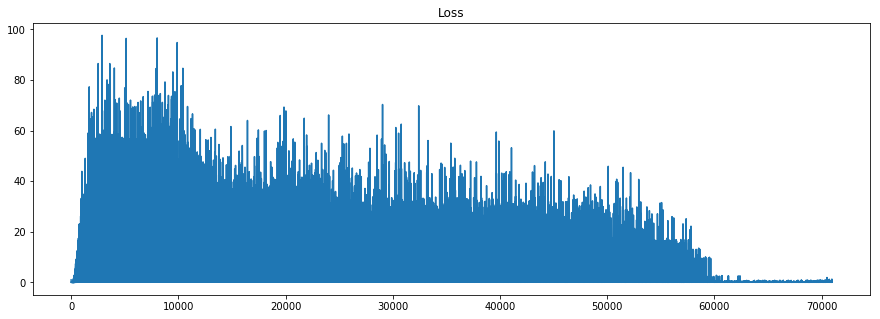

In [11]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [12]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 398, 0.05),
    ('MountainCar-v0', 530, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 398, 0.05),
 ('MountainCar-v0', 660, 0.1),
 ('LunarLander-v2', 260, 0.1)]